# Library Imports

In [1]:
import sys
import os
directory_path = os.path.abspath(os.path.join('..'))
utils_path = os.path.abspath(os.path.join('../utils'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    sys.path.append(utils_path)

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from utils.Validator import *
from utils.Combinations import *
pd.set_option('display.max_columns', None)  
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Network Data Preparation

## Users Followers

In [3]:
df_user_followers = pd.read_csv(r"../data/interim/UserFollowers.csv",dtype=str)
df_user_followers.head()

,UserId,FollowerUserId
0,368,993
1,368,1902
2,368,1950
3,368,3258
4,368,3429


In [4]:
df_user_followers.to_csv(r"../data/processed/DiGraph_Followers.csv",index=False)

## Users Teams

In [5]:
df_team_memberships = pd.read_csv(r"../data/interim/TeamMemberships.csv",dtype=str)
df_team_memberships.head()

,TeamId,UserId
0,518,635
1,526,839
2,527,816
3,528,778
4,529,747


In [6]:
df_team_memberships_graph = Combinations.create_combinations(df = df_team_memberships,group_by = "TeamId",name_col_1 ="UserId_1",name_col_2 = "UserId_2")
df_team_memberships_graph.head()


,TeamId,UserId_1,UserId_2
0,1000101,771602,611059
1,1000101,771602,599610
2,1000101,611059,599610
3,100044,2692,194687
4,100044,2692,208175


In [7]:
df_team_memberships_graph[df_team_memberships_graph["TeamId"]=="999285"]

,TeamId,UserId_1,UserId_2
252315,999285,443070,823629
252316,999285,443070,1382489
252317,999285,823629,1382489


In [51]:
df_team_memberships_graph_2 = df_team_memberships_graph[["UserId_1","UserId_2"]].groupby(["UserId_1","UserId_2"]).size().reset_index()
df_team_memberships_graph_2.rename(columns={0:"weight"},inplace=True)
df_team_memberships_graph_2.head()

,UserId_1,UserId_2,weight
0,10000270,8243312,3
1,10000270,9829581,2
2,1000033,1003122,1
3,1000033,1214207,1
4,1000033,1581982,1


In [52]:
print(df_team_memberships_graph.shape)
print(df_team_memberships_graph_2.shape)

(252332, 3)
(212459, 3)


In [54]:
#MultiGraph
df_team_memberships_graph_2.to_csv(r"../data/processed/Graph_Teams.csv",index=False)

## User Forum Messages

In [36]:
df_forum_messages = pd.read_csv(r"../data/interim/ForumMessages.csv",dtype=str)
df_forum_messages.head()

,ForumTopicId,UserId,Medal
0,2,368,NaN
1,16,368,NaN
2,16,368,NaN
3,20,368,NaN
4,20,368,NaN


In [37]:
print(df_forum_messages.shape)

(1308300, 3)


In [38]:
#Eliminamos los duplicados ya que no nos interesa si una persona comento 1 o 100 veces sobre un mismo foro, solo nos interesa si participo o no
df_forum_messages = df_forum_messages[["ForumTopicId","UserId"]].drop_duplicates()
print(df_forum_messages.shape)

(866218, 2)


In [39]:
df_forum_messages_size = df_forum_messages.groupby("ForumTopicId").size().to_frame('Comments').reset_index()
df_forum_messages_size.head()

,ForumTopicId,Comments
0,1,9
1,10,2
2,100,4
3,10000,2
4,100001,1


In [40]:
df_forum_messages = df_forum_messages.merge(df_forum_messages_size, how='left', on=['ForumTopicId'])
print(df_forum_messages.shape)

(866218, 3)


In [14]:
#Nos interesa foros donde al menos hayan interactuado 3 personas
df_forum_messages = df_forum_messages[df_forum_messages["Comments"]>2]
print(df_forum_messages.shape)

(673324, 3)


In [15]:
df_forum_messages.head()

,ForumTopicId,UserId,Comments
0,2,368,3
2,20,368,5
3,26,368,28
5,30,368,3
6,34,368,8


In [16]:
df_forum_messages["ForumTopicId_Int"] = df_forum_messages["ForumTopicId"].astype(int)
Validator.validar_numerico(df_forum_messages,["ForumTopicId_Int","Comments"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Unico,Media,Min,Max,IQRMAX,3STD,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,ForumTopicId_Int,673324,0,0.0,0,0.0,90592,161531.30,1,334076,486572.0,444784.68,157795.0,242882.0,296715.0,311888.0,329113.39,0,0.00,0,0.00,67332,10.00,33665,5.00,6734,1.0
0,Comments,673324,0,0.0,0,0.0,197,731.27,3,21282,50.0,11901.21,9.0,23.0,80.0,673.0,21282.00,88979,13.21,21282,3.16,67100,9.97,33374,4.96,0,0.0


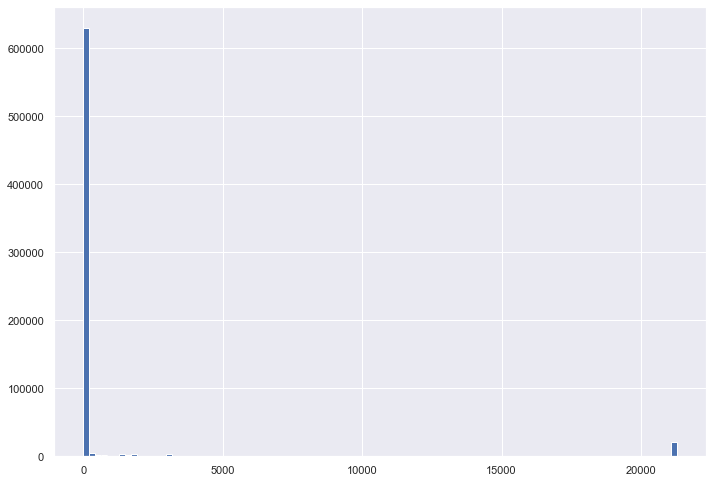

In [17]:
plt.hist(df_forum_messages["Comments"],bins=100)
plt.show()

In [18]:
df_forum_messages[df_forum_messages["Comments"]>80].head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int
252,35118,368,122,35118
261,60914,368,659,60914
271,137078,368,101,137078
583,36940,464,187,36940
616,111053,583,21282,111053


In [19]:
df_forums = pd.read_csv(r"../data/interim/Forums.csv",dtype=str)
df_forums.head()

,ForumId,ParentForumId,Title
0,1,8,Predict HIV Progression
1,2,8,Forecast Eurovision Voting
2,3,8,World Cup 2010 - Take on the Quants
3,4,8,INFORMS Data Mining Contest 2010
4,5,NaN,Active Competitions


In [20]:
df_forum_topics = pd.read_csv(r"../data/interim/ForumTopics.csv",dtype=str)
df_forum_topics.head()

,ForumTopicId,ForumId,Title,TotalViews,TotalMessages,Score
0,1,1,A few techniques you might try:,9405.0,19.0,0.0
1,2,1,Question regarding algorithms used,2185.0,3.0,0.0
2,3,1,Question about data,2121.0,3.0,0.0
3,4,1,Biased sets,2780.0,4.0,1.0
4,5,1,Non-standard nucleotide codings,2045.0,2.0,0.0


In [21]:
df_forums_2 = df_forums.copy()
df_forums_2 = df_forums_2[["ForumId","ParentForumId","Title"]]
df_forum_topics = df_forum_topics[["ForumTopicId","ForumId"]]
df_forum_topics_merge = df_forum_topics.merge(df_forums_2,how="left",on=["ForumId"])
df_forum_topics_merge.rename(columns={"Title":"ForumTopicName"},inplace=True)

#Cambio el codigo del foro para sacar el nombre del padre
df_forums_parent = df_forums_2.copy()
df_forums_parent = df_forums_parent["ParentForumId"].dropna()
df_forums_2 = df_forums_2[["ForumId","Title"]]
df_forums_2.rename(columns={"ForumId":"ParentForumId","Title":"ParentForumName"},inplace=True)
df_forum_topics_merge_2 = df_forum_topics_merge.merge(df_forums_2,how="left",on=["ParentForumId"])

df_forum_topics_merge_2.head()

,ForumTopicId,ForumId,ParentForumId,ForumTopicName,ParentForumName
0,1,1,8,Predict HIV Progression,Past Competitions
1,2,1,8,Predict HIV Progression,Past Competitions
2,3,1,8,Predict HIV Progression,Past Competitions
3,4,1,8,Predict HIV Progression,Past Competitions
4,5,1,8,Predict HIV Progression,Past Competitions


In [22]:
df_forum_topics_merge_2["ParentForumName"].value_counts()

General                65287
Past Competitions      64636
Public Datasets        16330
Active Competitions     2524
Name: ParentForumName, dtype: int64

In [23]:
df_forum_topics_merge_2["ParentForumId"].value_counts()

9       65287
8       64636
1023    16330
5        2524
52        544
6         456
198       335
91        214
Name: ParentForumId, dtype: int64

In [24]:
df_forum_topics_merge_2[df_forum_topics_merge_2["ParentForumId"]=="52"].head()

,ForumTopicId,ForumId,ParentForumId,ForumTopicName,ParentForumName
21661,856,54,52,UW STAT331 Linear Models Contest,NaN
21662,857,54,52,UW STAT331 Linear Models Contest,NaN
21663,858,54,52,UW STAT331 Linear Models Contest,NaN
21664,859,54,52,UW STAT331 Linear Models Contest,NaN
21665,860,54,52,UW STAT331 Linear Models Contest,NaN


In [25]:
df_forums[df_forums["ForumId"]=="51"]

,ForumId,ParentForumId,Title
24,51,8,Give Me Some Credit


In [26]:
df_forum_join = df_forum_messages.merge(df_forum_topics_merge_2,how="left",on=["ForumTopicId"])
df_forum_join.head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int,ForumId,ParentForumId,ForumTopicName,ParentForumName
0,2,368,3,2,1,8,Predict HIV Progression,Past Competitions
1,20,368,5,20,1,8,Predict HIV Progression,Past Competitions
2,26,368,28,26,15,9,General,General
3,30,368,3,30,4,8,INFORMS Data Mining Contest 2010,Past Competitions
4,34,368,8,34,4,8,INFORMS Data Mining Contest 2010,Past Competitions


<AxesSubplot:xlabel='ParentForumName', ylabel='Comments'>

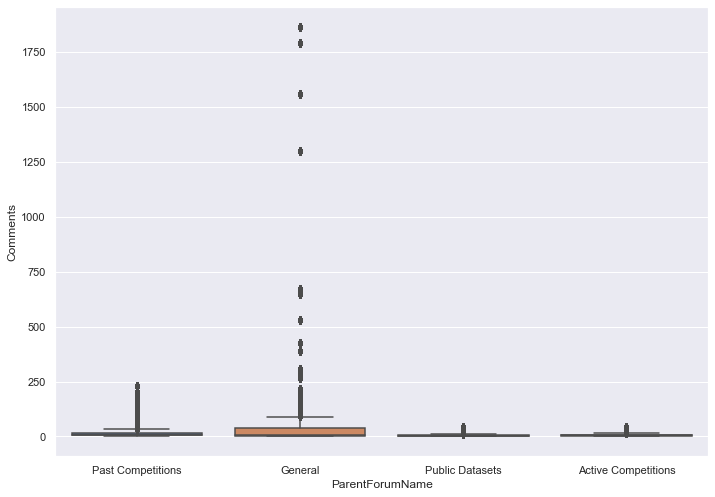

In [27]:
#Observamos que la mayoria de ForumParents que tienen mas de 250 comentarios son del general, asi que haremos un zoom sobre cuales son
sns.boxplot(data=df_forum_join, x='ParentForumName', y='Comments')

In [28]:
df_forum_join[df_forum_join["Comments"]>250]["ParentForumName"].value_counts()

General    11596
Name: ParentForumName, dtype: int64

In [29]:
df_forum_join[df_forum_join["Comments"]>250].head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int,ForumId,ParentForumId,ForumTopicName,ParentForumName
164,60914,368,659,60914,15,9,General,General
363,111053,583,21282,111053,16860,NaN,Notebooks,NaN
691,256646,937,3105,256646,16860,NaN,Notebooks,NaN
1286,111053,1327,21282,111053,16860,NaN,Notebooks,NaN
1409,256489,1408,1789,256489,208,9,Getting Started,General


<AxesSubplot:xlabel='ForumTopicName', ylabel='Comments'>

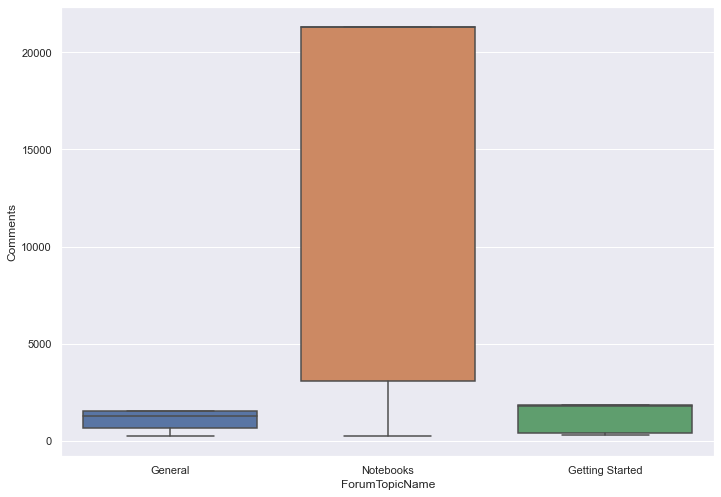

In [30]:
#Los foros con mas de 250 comentarios son los foros generales, de un notebook en particular o de uno de la categoria "iniciando"
sns.boxplot(data=df_forum_join[df_forum_join["Comments"]>250], x='ForumTopicName', y='Comments')

In [31]:
df_forum_messages.head()

,ForumTopicId,UserId,Comments,ForumTopicId_Int
0,2,368,3,2
2,20,368,5,20
3,26,368,28,26
5,30,368,3,30
6,34,368,8,34


In [32]:
#Decidimos prescindir de estos foros que tiene >250 mensajes y que representan menos del 10% del dataset
df_forum_messages = df_forum_messages[df_forum_messages["Comments"]<250]
Validator.validar_numerico(df_forum_messages,["ForumTopicId_Int","Comments"])

,Variable,n,Missing,%Missing,Negativo,%Negativo,Unico,Media,Min,Max,IQRMAX,3STD,P50,P75,P90,P95,P99,Outlier IQR,%Outlier IQR,Outlier 3SD,%Outlier 3SD,Outlier P90,%Outlier P90,Outlier P95,%Outlier P95,Outlier P99,%Outlier P99
0,ForumTopicId_Int,630785,0,0.0,0,0.0,90563,164250.1,1,334076,492841.0,450294.54,163754.0,245188.0,298491.0,313142.0,329372.0,0,0.00,0,0.00,63075,10.00,31538,5.0,6305,1.00
0,Comments,630785,0,0.0,0,0.0,169,18.1,3,244,37.5,102.30,8.0,18.0,40.0,68.0,163.0,68213,10.81,16911,2.68,62516,9.91,31528,5.0,6182,0.98


In [33]:
df_forum_messages_graph = Combinations.create_combinations(df = df_forum_messages[["ForumTopicId","UserId"]],group_by = "ForumTopicId",name_col_1 ="UserId_1",name_col_2 = "UserId_2")
df_forum_messages_graph.head()


,ForumTopicId,UserId_1,UserId_2
0,1,368,478
1,1,368,673
2,1,368,703
3,1,368,728
4,1,368,808


In [48]:
df_forum_messages_graph_2 = df_forum_messages_graph[["UserId_1","UserId_2"]].groupby(["UserId_1","UserId_2"]).size().reset_index()
df_forum_messages_graph_2.rename(columns={0:"weight"},inplace=True)
df_forum_messages_graph_2.head()

,UserId_1,UserId_2,weight
0,10000014,10030651,7
1,10000014,10135089,1
2,10000014,10275991,4
3,10000014,10352854,1
4,10000014,10454992,1


In [49]:
print(df_forum_messages_graph.shape)
print(df_forum_messages_graph_2.shape)

(5392174, 3)
(4306750, 3)


In [55]:
#MultiGraph
df_forum_messages_graph_2.to_csv(r"../data/processed/Graph_ForumMessages.csv",index=False)